This Python Jupyter Notebook models the performnance of alkaline water electrolyser under different conditions and implements artificial intelligence (AI) to predict cell efficiency. The model aslo uses an array of power instead of current to compute volatge, which is achieved using newton raphson method. The code simulates electrochemical processes, calculates key parameters like hydrogen yield, potentials and efficiencies,and presents results through interactive plots. The model then make use of a neural network to predict efficiency based on temperature, pressure, and power inputs.

In [ ]:
# Import dependencies
import tensorflow as tf
import numpy  as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation 
from matplotlib.animation import PillowWriter
from scipy.optimize import root

In [ ]:
# Function to calculate reversible voltage based on temperature
def E_rev_temp (Tcelcius):
    T=Tcelcius+273
    return (1.5184-(1.5421*10**-3)*T)+(9.523*10**-5*T*np.log(T))+(9.84*10**-8*T**2)
# Function to Calculate thermoneutral voltage under standard conditions
def Vth_standard ():
   enthalpy=285.83 # kj/mol
   f=96485 #c/mol
   return (enthalpy*1000)/(f*2) #j/c or volt

vth_std=Vth_standard()
print(f'this is Vth at std cond using enthalpy {vth_std}')

# Function to Calculate thermoneutral voltage at varied temperature and pressure
def Vth(Tcelcius,Pr,Tinitial=25):
    T=Tcelcius+273
    T0=Tinitial+273
    # calculation of vth at standard conditions 25 degrres and 1 bar 
    v_T_1= (1.485-(1.49*10**-4)*(T-T0))-(9.84*10**-8*(T-T0)**2)
    # parameters for improved accuracy 
    # parameters
    c1=-351
    c2=12760
    C= c1 + (c2/T**1/2)
    b1=20.5
    b2=-1857
    B=b1+(b2/T)
    dB_dT=b2/T**2
    c2=12760
    dC_dT= c2/T**3/2
    Rpg=8.3145
    F=96485 

    H_T_P =(v_T_1*2*F)+ (B-(T*dB_dT))*(Pr)+ ((C-B**2)-(0.5*T*(dC_dT-(2*B*dB_dT))))*(Pr**2)/(Rpg*T)
    return H_T_P /(2*F)
    
vth= Vth(Tcelcius=25,Pr=1)
# print(f'this is the thermoneutral voltage {vth}')

# Function to account for pressure in reversible voltage 
def pressure_add_erev(Pressure,T_inKelvin):
    return ((3*8.3145*T_inKelvin)/(4*96485))*np.log(Pressure)

# Function to calculate activation overpotential
def activation_ov(temperature,pressure,currentdensity):
  r1 = 4.45153*10**-5
  r2 =6.88874*10**-9 
  d1 =-3.12996*10**-6 
  d2 =4.47137*10**-7 
  return ((r1 + d1) +(r2*temperature)  + (d2*pressure))*currentdensity
actiOv_t_p=[]

# Function to calculate ohmic overpotential
def ohmic_ov (temperature,currentdensity):
  s =0.33824 
  t1 =-0.01539 
  t2 =2.00181
  t3 =15.24178
  x=(t1+(t2/temperature)+(t3/temperature**2))
  ohmicvoltage= s*(np.log10((x*(currentdensity))+1))
  return ohmicvoltage

# Function to calculate Faraday efficiency
def faraday_ef(T,i):
 f11=478645.74
 f12=-2953.15
 f21= 1.03960
 f22=-0.00104
 return (i**2/(f11+f12+i**2))*(f21+(f22*T))

# Function calculate hydrogen yield per cell
def cell_hydrogen_yield (current,faradayeff):
  # electron transfered 
  z=2 
  #faraday coefficient 
  F=96485 
  # mol/s
  H2prod = faradayeff*(current/(z*F))
  # % mol/s*3600s/h then divide by 44.618 mol/Nm^3 to get H2 in Nm^3/h
  H2 = (H2prod*3600)/44.618
  return H2

# Calculate voltage and current from power using newton raphson method to avoid algebraic loop error

def voltage (power,pressure,Temp,n=12,A=0.1):

       
        T_kelvinT=Temp+273
      
        E_rev_tempT=E_rev_temp(Temp)
     
        pressure_add_erevT=pressure_add_erev(pressure,T_kelvinT)
        # merge the 2 through nympy to create the reversible voltage
        Erev_T_PT= E_rev_tempT + pressure_add_erevT
      
        def volt (x,power):
            voltage,current =x
            # if power ==0 :
            #    return current-0,voltage-Erev_T_PT
            # else:
            Icell=(power*1000)/(n*voltage)
            Cur_dens=Icell/A
            return (current-Icell),voltage-(Erev_T_PT+activation_ov(Temp,pressure,Cur_dens)+ohmic_ov(Temp,Cur_dens))
        solution= root(volt,[1,1],args=(power))
        voltage,current = solution.x
        return current,voltage



this is Vth at std cond using enthalpy 1.4812146965849613
this is the thermoneutral voltage 1.4851049329452124


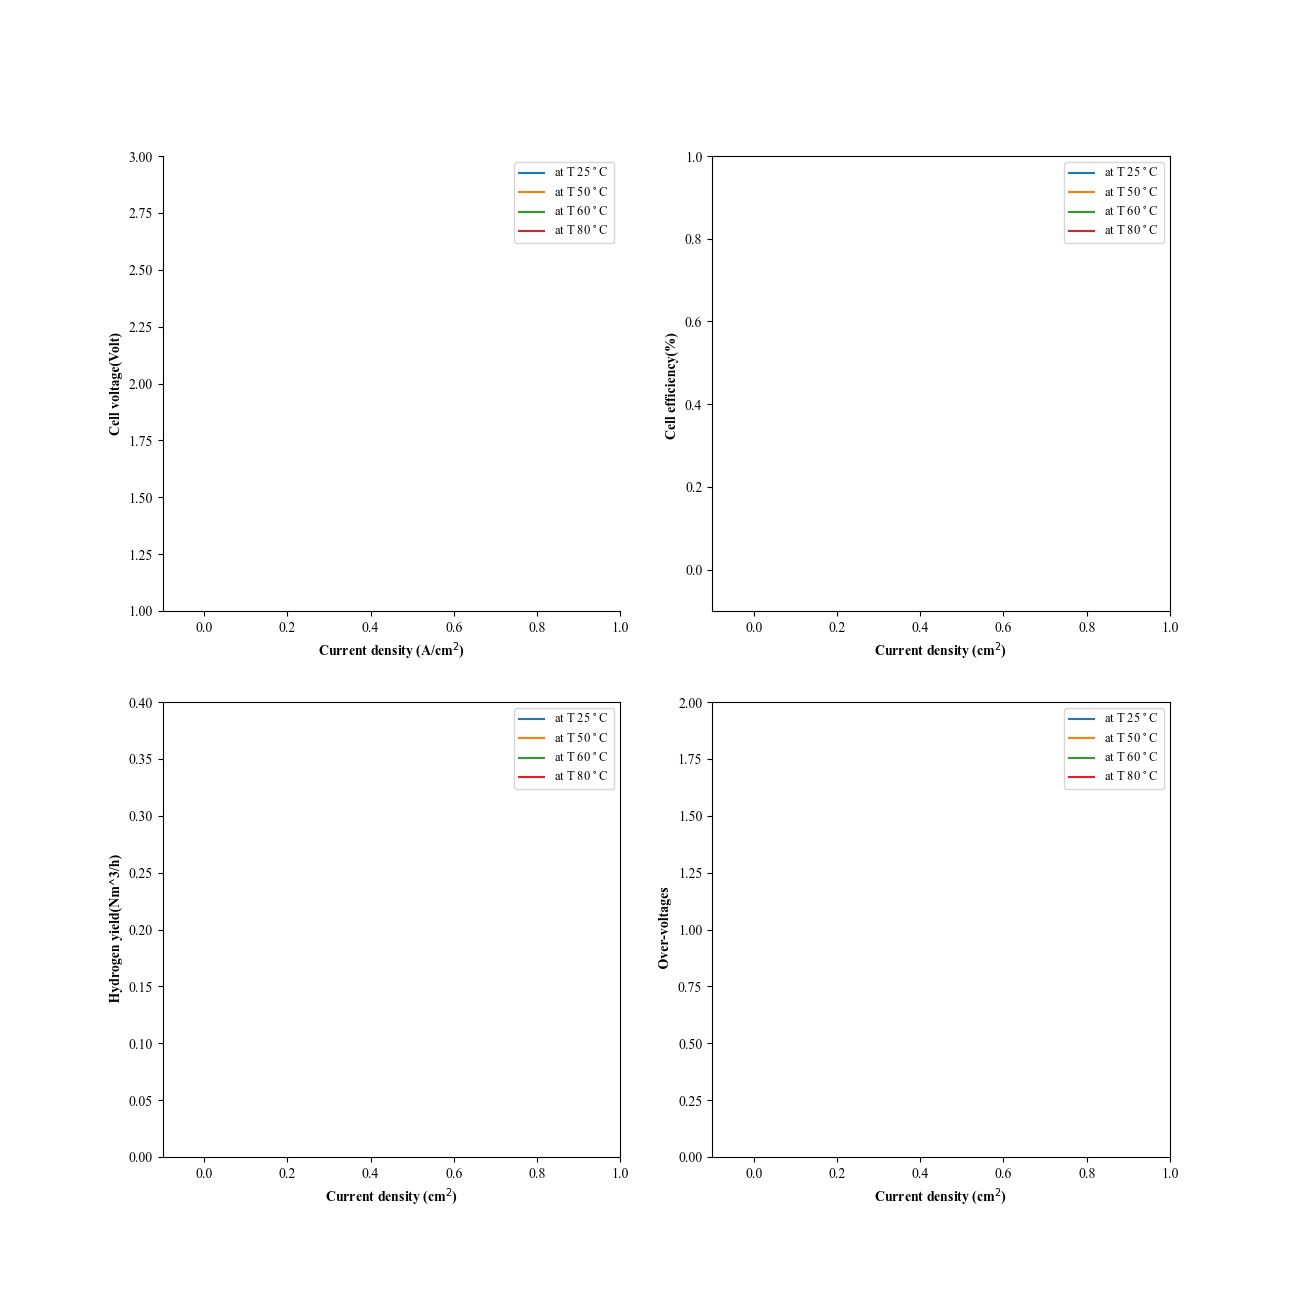

In [ ]:
# For interactive plotting
%matplotlib  widget 

# Main arrays
n=1000
Powers = np.linspace(0,20,n) # using linspace function to get n numbers from 1 to 20 kw
Temperatures = np.array([25,50,60,80]) # Operating temperatures 
Pressures = np.array([1,3,5,10,12]) # Operating pressures

# 3D arrays for outputs
voltages=[]
Thermoneutral_voltages=[]
Currents=[]
Current_density=[]
Current_density_cm=[]
Overvoltages=[]
Cell_Efficiency=[]
Faraday_Efficiency=[]
Energy_Efficciency=[]
Stack_Efficiency=[]
Hydrogen_yield_cell=[]
Hydrogen_yield_stack=[]

# 3D result arrays 
current_LIST_3d=[]
volt_LIST_3d=[]
current_dens_cm_LIST_3d=[]
Erev_T_PT_LIST_3d=[]
overvoltages_LIST_3d=[]
farad_efficiency_LIST_3d=[]
Energy_Efficc_LIST_3d=[]
cell_eff_LIST_3d=[]
H2_yield_LIST_3d=[]
Temperature_List_3d=[]
Pressure_List_3d=[]
Power_List_3d=[]

## Main electrolyser function

def electrolyser (pressures=Pressures ,temperatures=Temperatures ,powers=Powers,A=0.1):
    
    for pressure in pressures:
     
        current_LIST_2d=[]
        volt_LIST_2d=[]
        current_dens_cm_LIST_2d=[]
        Erev_T_PT_LIST_2d=[]
        overvoltages_LIST_2d=[]
        farad_efficiency_LIST_2d=[]
        Energy_Efficc_LIST_2d=[]
        cell_eff_LIST_2d=[]
        H2_yield_LIST_2d=[]
        temperature_list_2d=[]
        pressure_list_2d=[]
        power_list_2d=[]
 
        for temperature in temperatures:
           
           current_LIST=[]
           volt_LIST=[]
           current_dens_cm_LIST=[]
           Erev_T_PT_LIST=[]
           overvoltages_LIST=[]
           farad_efficiency_LIST=[]
           Energy_Efficc_LIST=[]
           cell_eff_LIST=[]
           H2_yield_LIST=[]
           temperature_list=[]
           pressure_list=[]
           Power_List=[]

           for power in powers: 
              current,volt= voltage(power=power,pressure=pressure,Temp=temperature)
              current_density= current/A
              current_dens_cm = current_density/10000
              overvoltages= activation_ov(temperature,pressure,current_density)+ohmic_ov(temperature,current_density)
              T_kelvinT=temperature+273
              E_rev_tempT=E_rev_temp(temperature)
              pressure_add_erevT=pressure_add_erev(pressure,T_kelvinT)
              Erev_T_PT= (E_rev_tempT + pressure_add_erevT)
              farad_efficiency= faraday_ef(temperature,current_density)
              Energy_Efficc= Erev_T_PT/volt
              cell_eff= (Energy_Efficc*farad_efficiency)
              H2_yield=cell_hydrogen_yield(current,farad_efficiency)

              temperature_list.append(temperature)
              pressure_list.append(pressure)
              Power_List.append(power)
              current_LIST.append(current) 
              volt_LIST.append(volt)
              current_dens_cm_LIST.append(current_dens_cm)
              Erev_T_PT_LIST.append(Erev_T_PT)
              overvoltages_LIST.append(overvoltages)
              farad_efficiency_LIST.append(farad_efficiency)
              Energy_Efficc_LIST.append(Energy_Efficc)
              cell_eff_LIST.append(cell_eff)
              H2_yield_LIST.append(H2_yield)
            
           # Store 1D arrays into 2D
           current_LIST_2d.append(current_LIST)
           volt_LIST_2d.append(volt_LIST)
           current_dens_cm_LIST_2d.append(current_dens_cm_LIST)
           Erev_T_PT_LIST_2d.append(Erev_T_PT_LIST)
           overvoltages_LIST_2d.append(overvoltages_LIST)
           farad_efficiency_LIST_2d.append(farad_efficiency_LIST)
           Energy_Efficc_LIST_2d.append(Energy_Efficc_LIST)
           cell_eff_LIST_2d.append(cell_eff_LIST)
           H2_yield_LIST_2d.append(H2_yield_LIST)
           temperature_list_2d.append(temperature_list)
           pressure_list_2d.append(pressure_list)
           power_list_2d.append(Power_List)

        # Store 2D arrays into 3D
        current_LIST_3d.append(current_LIST_2d)
        volt_LIST_3d.append(volt_LIST_2d)
        current_dens_cm_LIST_3d.append( current_dens_cm_LIST_2d)
        Erev_T_PT_LIST_3d.append(Erev_T_PT_LIST_2d)
        overvoltages_LIST_3d.append(overvoltages_LIST_2d)
        farad_efficiency_LIST_3d.append(farad_efficiency_LIST_2d)
        Energy_Efficc_LIST_3d.append(Energy_Efficc_LIST_2d)
        cell_eff_LIST_3d.append(cell_eff_LIST_2d)
        H2_yield_LIST_3d.append(H2_yield_LIST_2d)
        Temperature_List_3d.append(temperature_list_2d)
        Pressure_List_3d.append(pressure_list_2d)
        Power_List_3d.append(power_list_2d)


electrolyser()

# Sample data used for plotting
volt_sample=volt_LIST_3d[0][0]
cur_dens_sample=current_dens_cm_LIST_3d[0][0]
cell_eff_sample= cell_eff_LIST_3d[0][0]
farad_ef_sample =  farad_efficiency_LIST_3d[0][0]
En_ef_sample=Energy_Efficc_LIST_3d
rev_sample = Erev_T_PT_LIST_3d[0][0]


# Set up figure and subplots for animation
Fig,((ax1,ax2),(ax3,ax4))=plt.subplots(2,2,figsize=(13,13))

# Voltage lines   
voltChange_line1, = ax1.plot([],[],label=f'at T {Temperatures[0]}$^\circ$C')
voltChange_line2, = ax1.plot([],[],label=f'at T {Temperatures[1]}$^\circ$C')
voltChange_line3, = ax1.plot([],[],label=f'at T {Temperatures[2]}$^\circ$C')
voltChange_line4 ,= ax1.plot([],[],label=f'at T {Temperatures[3]}$^\circ$C')
ax1.legend(loc="upper right",prop={'size':9})
volt_lines =[voltChange_line1,voltChange_line2,voltChange_line3,voltChange_line4]
 
# Cell efficiency lines
cellChange_line1, = ax2.plot([],[],label=f'at T {Temperatures[0]}$^\circ$C')
cellChange_line2, = ax2.plot([],[],label=f'at T {Temperatures[1]}$^\circ$C')
cellChange_line3, = ax2.plot([],[],label=f'at T {Temperatures[2]}$^\circ$C')
cellChange_line4 ,= ax2.plot([],[],label=f'at T {Temperatures[3]}$^\circ$C')
ax2.legend(loc="upper right",prop={'size':9})
cell_lines =[cellChange_line1,cellChange_line2,cellChange_line3,cellChange_line4]

# Hydrogen yield lines
yieldChange_line1, = ax3.plot([],[],label=f'at T {Temperatures[0]}$^\circ$C')
yieldChange_line2, = ax3.plot([],[],label=f'at T {Temperatures[1]}$^\circ$C')
yieldChange_line3, = ax3.plot([],[],label=f'at T {Temperatures[2]}$^\circ$C')
yieldChange_line4 ,= ax3.plot([],[],label=f'at T {Temperatures[3]}$^\circ$C')
ax3.legend(loc="upper right",prop={'size':9})
yield_lines =[yieldChange_line1,yieldChange_line2,yieldChange_line3,yieldChange_line4]

# Overvoltages lines  
heatChange_line1, = ax4.plot([],[],label=f'at T {Temperatures[0]}$^\circ$C')
heatChange_line2, = ax4.plot([],[],label=f'at T {Temperatures[1]}$^\circ$C')
heatChange_line3, = ax4.plot([],[],label=f'at T {Temperatures[2]}$^\circ$C')
heatChange_line4 ,= ax4.plot([],[],label=f'at T {Temperatures[3]}$^\circ$C')
ax4.legend(loc="upper right",prop={'size':9})
heat_lines =[heatChange_line1,heatChange_line2,heatChange_line3,heatChange_line4]

# Combine all the lines
lines=[*volt_lines,*cell_lines,*yield_lines,*heat_lines]

# set up axes
ax1.set_xlim(-0.1,1)
ax1.set_ylim(1,3)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

ax2.set_xlim(-0.1,1)
ax2.set_ylim(-0.1,1)


ax3.set_xlim(-0.1,1)
ax3.set_ylim(0,0.4)

ax4.set_xlim(-0.1,1)
ax4.set_ylim(0,2)

ax1.set_xlabel('Current density (A/cm$^{2}$)',fontweight='bold',animated=True)
ax1.set_ylabel('Cell voltage(Volt)',fontweight='bold')

ax2.set_xlabel('Current density (cm$^{2}$)',fontweight='bold')
ax2.set_ylabel('Cell efficiency(%) ',fontweight='bold')

ax3.set_xlabel('Current density (cm$^{2}$)',fontweight='bold')
ax3.set_ylabel(' Hydrogen yield(Nm^3/h)',fontweight='bold')

ax4.set_xlabel('Current density (cm$^{2}$)',fontweight='bold')
ax4.set_ylabel(' Over-voltages',fontweight='bold')

# Function updater for animation

def buildframes (i):
    for run in range(len(Temperatures)):
        volt_lines[run].set_data(current_dens_cm_LIST_3d[0][run][:i+1],volt_LIST_3d[0][run][:i+1])
        cell_lines[run].set_data(current_dens_cm_LIST_3d[0][run][:i+1],cell_eff_LIST_3d[0][run][:i+1])
        yield_lines[run].set_data(current_dens_cm_LIST_3d[0][run][:i+1],H2_yield_LIST_3d[0][run][:i+1])
        heat_lines[run].set_data(current_dens_cm_LIST_3d[0][run][:i+1],overvoltages_LIST_3d[0][run][:i+1])
    return lines,
    
# Create animation 
# the number of frame should have the same dimention as the data in the function 
# interval is the delay between frames in miliseconds 
ani=animation.FuncAnimation(Fig,buildframes,frames=len(Powers),interval=50,repeat=False)



ANN AI Modelling For cell Efficiency  

In [ ]:
# Flatten 3D data for AI input
temp_data = np.array(Temperature_List_3d).flatten()
pressure_data = np.array(Pressure_List_3d).flatten()
voltage_data = np.array(volt_LIST_3d).flatten()
power_data = np.array(Power_List_3d).flatten()
efficiency_data= np.array(cell_eff_LIST_3d).flatten()
Hydrogen_data= np.array(H2_yield_LIST_3d).flatten()
# print(temp_data.shape)
# print(pressure_data.shape)
# print(voltage_data.shape)
# print(power_data.shape)
# print(efficiency_data.shape)
# print(Hydrogen_data.shape)




(20000,)
(20000,)
(20000,)
(20000,)
(20000,)
(20000,)


In [ ]:

#  Creating dataframe with panda
dataframe = pd.DataFrame({
    'temperature': temp_data,
    'pressure':pressure_data,
    'power':power_data,
    'efficiency': efficiency_data,
    'hydrogen':Hydrogen_data   
})
# pd.set_option('display.max_rows', 1000)
print(dataframe)

       temperature  pressure     power  efficiency      hydrogen
0               25         1   0.00000    0.000000  0.000000e+00
1               25         1   0.02002    0.000303  1.721022e-07
2               25         1   0.04004    0.001067  1.210631e-06
3               25         1   0.06006    0.002201  3.746921e-06
4               25         1   0.08008    0.003664  8.317072e-06
...            ...       ...       ...         ...           ...
19995           80        12  19.91992    0.522680  2.925179e-01
19996           80        12  19.93994    0.522592  2.927631e-01
19997           80        12  19.95996    0.522505  2.930082e-01
19998           80        12  19.97998    0.522418  2.932533e-01
19999           80        12  20.00000    0.522331  2.934982e-01

[20000 rows x 5 columns]


In [ ]:
# Data  splitting into input and output
input_data= dataframe[['temperature','pressure','power']]
output_data_efficiency= dataframe[[ 'efficiency']]
output_data_hydrogen= dataframe[['hydrogen']]

# Split data: 80% training, 10% evaluation, 10% testing
ntop= 80
nbot=10
ntest=10
# training input data. 70 % of the training data
train_input_data=input_data.head(n=int(len(input_data)*(ntop/100)))
# evaluation input data . 30 % of the training data
eva_input_data=input_data.head(n=int(len(input_data)*(nbot/100)))
# test data 
test_input_data=input_data.head(n=int(len(input_data)*(ntest/100)))

# training output data. 70% of the training data
train_output_data= output_data_efficiency.head(n=int(len(output_data_efficiency)*(ntop/100)))
# evaluation output data . 30 % of the training data
eva_output_data= output_data_efficiency.head(n=int(len(output_data_efficiency)*(nbot/100)))
# test
test_output_data= output_data_efficiency.head(n=int(len(output_data_efficiency)*(ntest/100)))



In [ ]:
# creating a tensorflow feature(input) columns, made of numberical columns 
features_colums= []
# define numerical colums list, basically the header of each column 
numerical_colums=['temperature','pressure','power']
#  define tensorflow feature columns and append them to the feature list
for feature_name in numerical_colums:
 features_colums.append(tf.feature_column.numeric_column(feature_name,dtype=tf.float32))
# feature_column.numeric_column should return an object with key as feature name, type and shape can also be specified 




In [ ]:
# Define the input function for TensorFlow
def make_input_func(input_dataframe,label_dataframe,epochs_num=10,shuffle=True,batch_size=10):
    # creating the input dataset fuynction 
    def input_fn():
        ds= tf.data.Dataset.from_tensor_slices((dict(input_dataframe), label_dataframe))
        if shuffle:
            ds= ds.shuffle(100)
        ds= ds.batch(batch_size).repeat(epochs_num)
        return ds 
    return input_fn

# Loading the training and evaluation functionS 
training_fn= make_input_func(train_input_data,train_output_data)
eva_fn= make_input_func(eva_input_data,eva_output_data,epochs_num=10,shuffle=True)
# Should return the training and evation functions which in turn return the dataset 
 

 Kera ANN Model

In [ ]:
# Imports
from tensorflow import keras  
from keras.callbacks import TensorBoard
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
import os



In [ ]:
# TensorBoard setup
# Create a log directory: Specify a directory to store the TensorBoard logs. Each run of the training can be logged separately.
log_dir = os.path.join("logs", "fit", "model_graph")
# This callback will save the training logs so that you can visualize them in TensorBoard.
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1, write_graph=True)

scaler = MinMaxScaler()

# split the data for kera into training, validation, and test sets, with test representing 15% of the data
input_train_val, input_test, output_train_val, output_test = train_test_split(input_data, output_data_efficiency, test_size=0.15, random_state=42)
# Using 15% for validation
input_train, input_val, output_train, output_val = train_test_split(input_train_val, output_train_val, test_size=0.15, random_state=42)

#  Creating a kera sequential model

model = tf.keras.models.Sequential()
# Configure each network layer
model.add(tf.keras.layers.Dense(units=32,input_shape=(3,),activation='relu'))
model.add(tf.keras.layers.Dense(units=64, activation='relu'))
model.add(tf.keras.layers.Dense(units=32, activation='relu'))
model.add(tf.keras.layers.Dense(units=16, activation='relu'))
model.add(tf.keras.layers.Dense(units=1, activation='linear'))

# Compile the model
# Also specifying  the loss function and optimizer.
model.compile(loss='MSE', optimizer='RMSprop',metrics=['accuracy'])

# Training the model
history=model.fit(input_train,output_train, epochs=50, batch_size=32,validation_data=(input_val, output_val),callbacks=[tensorboard_callback])




Epoch 1/50
452/452 [==============================] - 1s 1ms/step - loss: 0.1201 - accuracy: 6.9204e-04 - val_loss: 0.0554 - val_accuracy: 7.8431e-04
Epoch 2/50
452/452 [==============================] - 0s 1ms/step - loss: 0.0180 - accuracy: 8.9965e-04 - val_loss: 0.0079 - val_accuracy: 0.0016
Epoch 3/50
452/452 [==============================] - 0s 1ms/step - loss: 0.0060 - accuracy: 8.9965e-04 - val_loss: 0.0100 - val_accuracy: 0.0016
Epoch 4/50
452/452 [==============================] - 0s 1ms/step - loss: 0.0029 - accuracy: 8.9965e-04 - val_loss: 0.0033 - val_accuracy: 0.0016
Epoch 5/50
452/452 [==============================] - 1s 1ms/step - loss: 0.0018 - accuracy: 8.9965e-04 - val_loss: 0.0014 - val_accuracy: 0.0016
Epoch 6/50
452/452 [==============================] - 1s 1ms/step - loss: 0.0011 - accuracy: 8.9965e-04 - val_loss: 0.0019 - val_accuracy: 0.0016
Epoch 7/50
452/452 [==============================] - 1s 1ms/step - loss: 8.3251e-04 - accuracy: 8.9965e-04 - val_loss: 

Evaluate the Model

94/94 [==============================] - 0s 699us/step - loss: 1.1697e-04 - accuracy: 0.0010
loss: [0.00011696728324750438, 0.0010000000474974513]
94/94 [==============================] - 0s 609us/step
Mean Absolute Error (MAE): 0.007561226625749501
R² score: 0.9900300530324677


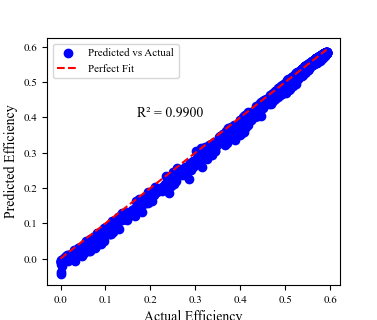

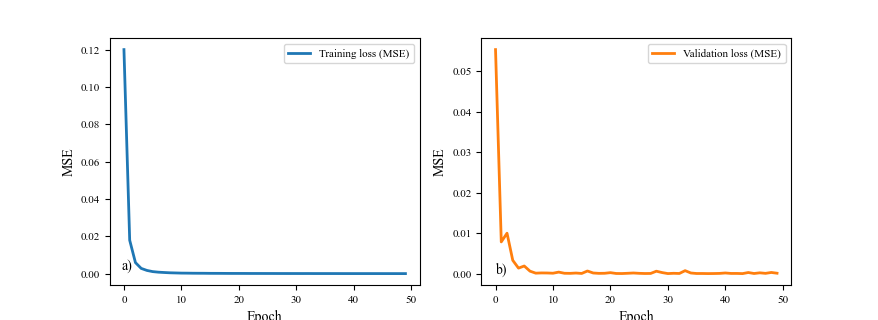

In [ ]:
plt.rcParams["font.family"] = "Times New Roman "

loss= model.evaluate(input_test, output_test)
print('loss:',loss)

# Make predictions
predictions = model.predict(input_test)

# Compute MAE 
mae = mean_absolute_error(output_test, predictions)
print('Mean Absolute Error (MAE):', mae)

# Compute R² score
r2 = r2_score(output_test, predictions)
print('R² score:', r2)

output_test = np.array(output_test).astype(float)

# Plotting

# Plot actual vs predicted values of efficiency
plt.figure(figsize=(3.777, 3.2))
plt.scatter(output_test, predictions, color='blue', label='Predicted vs Actual')

plt.tick_params(axis='both', labelsize=8) 

# Plot the perfect correlation line (y=x line)
perfect_fit = np.linspace(min(output_test), max(output_test), 100)
plt.plot(perfect_fit, perfect_fit, color='red', linestyle='--', label='Perfect Fit')

# Add R² text on the plot
# Adjust the coordinates to place it at a suitable position on the plot
plt.text(0.17,0.4, f'R² = {r2:.4f}', fontsize=10, color='black')

# Add labels and title
plt.xlabel('Actual Efficiency', fontsize=10)
plt.ylabel('Predicted Efficiency', fontsize=10)
# plt.title('Correlation between Actual and Predicted Efficiency', fontsize=12)
plt.legend(loc="upper left",prop={'size':8})

# Show the plot
plt.show()
# plt.savefig("images/correlation4.tiff", format='tiff', dpi=500, bbox_inches='tight',bbox_extra_artists=[ax1.yaxis.label, ax2.yaxis.label],pil_kwargs={"compression": "tiff_lzw"})
# plt.figure(figsize=(8, 6))
# Plot MAE over epochs during training (if you want to monitor MAE during training)

# Plot training and validation loss
Fig2, (ax1, ax2) =plt.subplots(nrows=1, ncols=2,figsize=(8.79, 3.2 ) )
Fig2.subplots_adjust(wspace=0.2) 

# ax1.title('Training (MSE)',fontsize=12)
ax1.set_ylabel('MSE', fontsize=10)
ax1.set_xlabel('Epoch', fontsize=10)
ax1.text(-0.5, 0.002, 'a)',fontsize=10,)
ax1.tick_params(axis='both', labelsize=8) 
ax1.plot(history.history['loss'], label='Training loss (MSE)',linewidth=2)
ax1.legend(loc="upper right",prop={'size':8})

# ax2.title('Validation Loss (MSE)',fontsize=12)
ax2.set_ylabel('MSE', fontsize=10)
ax2.set_xlabel('Epoch', fontsize=10)
ax2.text(0, 0.000, 'b)',fontsize=10,)
ax2.tick_params(axis='both', labelsize=8) 
ax2.plot(history.history['val_loss'], label='Validation loss (MSE)',linewidth=2,color='C1')
ax2.legend(loc="upper right",prop={'size':8})

# Fig2.savefig("images/mse4.tiff", format='tiff', dpi=500, bbox_inches='tight',bbox_extra_artists=[ax1.yaxis.label, ax2.yaxis.label],pil_kwargs={"compression": "tiff_lzw"})

#  Launch TensorBoard for detailled evaluation of the model

# %tensorboard --logdir logs/fit


In [164]:
# making presdiction on new data 
# new_input_data = np.array([80,12,20])
# predictions = model.predict(new_input_data)